In [68]:
# ???
# idea: multi-qubit gates formed by 2Q interactions, similar to multi-block
# maybe a V gate is defined by 2 points at iSwap, Delta by 3 points at iSwap
# gates can be defined by a vector of coordinates.
# only works because there is no 3Q interaction, just multiple 2Q interactions at the same time

In [69]:
# TODO
# given interaction sliders
# update colored points,
# update ouput final matrix

In [70]:
from abc import ABC
from ast import Pass
from hashlib import sha1

import numpy as np
import qutip
from weylchamber import c1c2c3, WeylChamber
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw

In [71]:
import ipywidgets as widgets


class QubitInteraction:
    def __init__(self, gc, gg, phi_c=0.0, phi_g=0.0):
        self.gc = gc
        self.gg = gg
        self.phi_c = phi_c
        self.phi_g = phi_g
        self.gc_slider = widgets.FloatSlider(
            value=gc, min=0, max=2 * np.pi, step=0.01, description="gc:"
        )
        self.gg_slider = widgets.FloatSlider(
            value=gg, min=0, max=2 * np.pi, step=0.01, description="gg:"
        )
        self.interact = widgets.interactive(
            self.update, gc=self.gc_slider, gg=self.gg_slider
        )

    def update(self, gc, gg):
        self.gc = gc
        self.gg = gg

    def display(self):
        return self.interact

    def construct_H(self, A, B):
        H_c = (
            np.exp(1j * self.phi_c) * A * B.dag()
            + np.exp(-1j * self.phi_c) * A.dag() * B
        )
        H_g = (
            np.exp(1j * self.phi_g) * A * B
            + np.exp(-1j * self.phi_g) * A.dag() * B.dag()
        )
        return self.gc * H_c + self.gg * H_g

In [72]:
import ipywidgets as widgets


class QubitInteraction:
    def __init__(self, gc, gg, phi_c=0.0, phi_g=0.0):
        self.gc = gc
        self.gg = gg
        self.phi_c = phi_c
        self.phi_g = phi_g
        self.gc_slider = widgets.FloatSlider(
            value=gc, min=0, max=2 * np.pi, step=0.01, description="gc:"
        )
        self.gg_slider = widgets.FloatSlider(
            value=gg, min=0, max=2 * np.pi, step=0.01, description="gg:"
        )
        self.interact = widgets.interactive(
            self.update, gc=self.gc_slider, gg=self.gg_slider
        )

    def update(self, gc, gg):
        self.gc = gc
        self.gg = gg

    def display(self):
        return self.interact

    def construct_H(self, A, B):
        H_c = (
            np.exp(1j * self.phi_c) * A * B.dag()
            + np.exp(-1j * self.phi_c) * A.dag() * B
        )
        H_g = (
            np.exp(1j * self.phi_g) * A * B
            + np.exp(-1j * self.phi_g) * A.dag() * B.dag()
        )
        return self.gc * H_c + self.gg * H_g


class Hamiltonian(ABC):
    def _construct_U_lambda(self):
        return lambda t: (-1j * t * self.H).expm()


class QubitSystem(Hamiltonian):
    def __init__(self, qubit_interactions, num_qubits):
        self.H = 0
        self.num_qubits = num_qubits
        self.qubit_interactions = qubit_interactions

        for qubit_interaction, qubit_pair in self.qubit_interactions:
            self.H += self.construct_interaction(qubit_interaction, qubit_pair)

    def construct_interaction(self, qubit_interaction, qubit_pair):
        a = qutip.operators.create(N=2)

        operators = [qutip.operators.identity(2) for _ in range(self.num_qubits)]
        operators[qubit_pair[0]] = a
        A = qutip.tensor(*operators)

        operators = [qutip.operators.identity(2) for _ in range(self.num_qubits)]
        operators[qubit_pair[1]] = a
        B = qutip.tensor(*operators)

        H_int = qubit_interaction.construct_H(A, B)
        return H_int

    def display(self):
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # Displaying sliders (QubitInteraction)
        for interaction, _ in self.qubit_interactions:
            display(interaction.display())

        # Qubit interactions graph
        G = rx.PyGraph()
        G.add_nodes_from(list(range(self.num_qubits)))
        for idx, (interaction, (q1, q2)) in enumerate(self.qubit_interactions):
            G.add_edge(q1, q2, interaction.gc)  # or other value for annotation
            axes[1].text(
                (q1 + q2) / 2, idx, f"{interaction.gc:.2f},{interaction.gg:.2f}"
            )

        mpl_draw(G, ax=axes[1], with_labels=True)

        # # Final computed unitary
        # U = self._construct_U_lambda()(t=1.0)  # Assuming U is computed this way
        # im = axes[2].imshow(np.abs(U), cmap="viridis")
        # fig.colorbar(im, ax=axes[2])

        plt.show()

In [73]:
# 2 qubit example, verify find iSwapGate
interaction = QubitInteraction(np.pi / 2, 0)
sys = QubitSystem([(interaction, (0, 1))], 2)
print(sys.H)
unitary = sys._construct_U_lambda()(t=1.0)
print(unitary)
print(c1c2c3(unitary))

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.         0.         0.         0.        ]
 [0.         0.         1.57079633 0.        ]
 [0.         1.57079633 0.         0.        ]
 [0.         0.         0.         0.        ]]
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.-1.j 0.+0.j]
 [0.+0.j 0.-1.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]
(0.5, 0.5, 0.0)


interactive(children=(FloatSlider(value=1.5707963267948966, description='gc:', max=6.283185307179586, step=0.0…

interactive(children=(FloatSlider(value=0.7853981633974483, description='gc:', max=6.283185307179586, step=0.0…

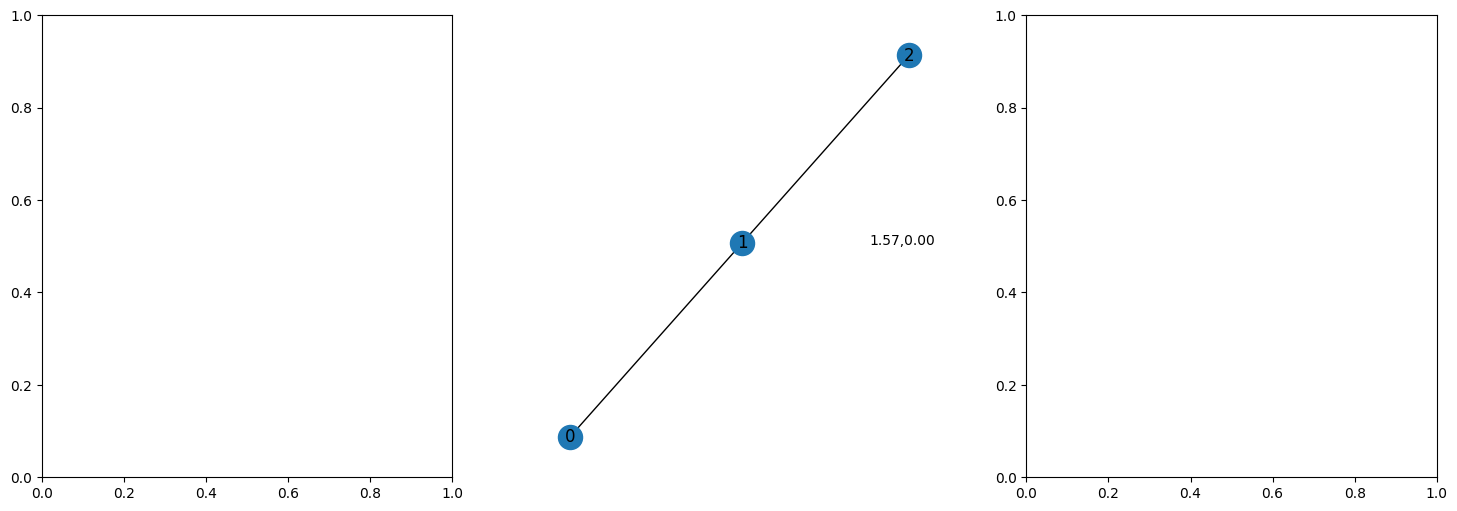

In [74]:
# building interactive example
interaction1 = QubitInteraction(np.pi / 2, 0)
interaction2 = QubitInteraction(np.pi / 4, np.pi / 4)
sys = QubitSystem([(interaction1, (0, 1)), (interaction2, (1, 2))], 3)
sys.display()

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = False
Qobj data =
[[ 0.76197608+0.j          0.        +0.j          0.        +0.j
   0.        -0.44800947j  0.        +0.j         -0.44800947+0.j
   0.        +0.13404286j  0.        +0.j        ]
 [ 0.        +0.j          0.76197608+0.j          0.        -0.44800947j
   0.        +0.j         -0.44800947+0.j          0.        +0.j
   0.        +0.j          0.        +0.13404286j]
 [ 0.        +0.j          0.        -0.44800947j -0.13404286+0.j
   0.        +0.j          0.        -0.76197608j  0.        +0.j
   0.        +0.j         -0.44800947+0.j        ]
 [ 0.        -0.44800947j  0.        +0.j          0.        +0.j
  -0.13404286+0.j          0.        +0.j          0.        -0.76197608j
  -0.44800947+0.j          0.        +0.j        ]
 [ 0.        +0.j         -0.44800947+0.j          0.        -0.76197608j
   0.        +0.j         -0.13404286+0.j          0.        +0.j
   0.    

None

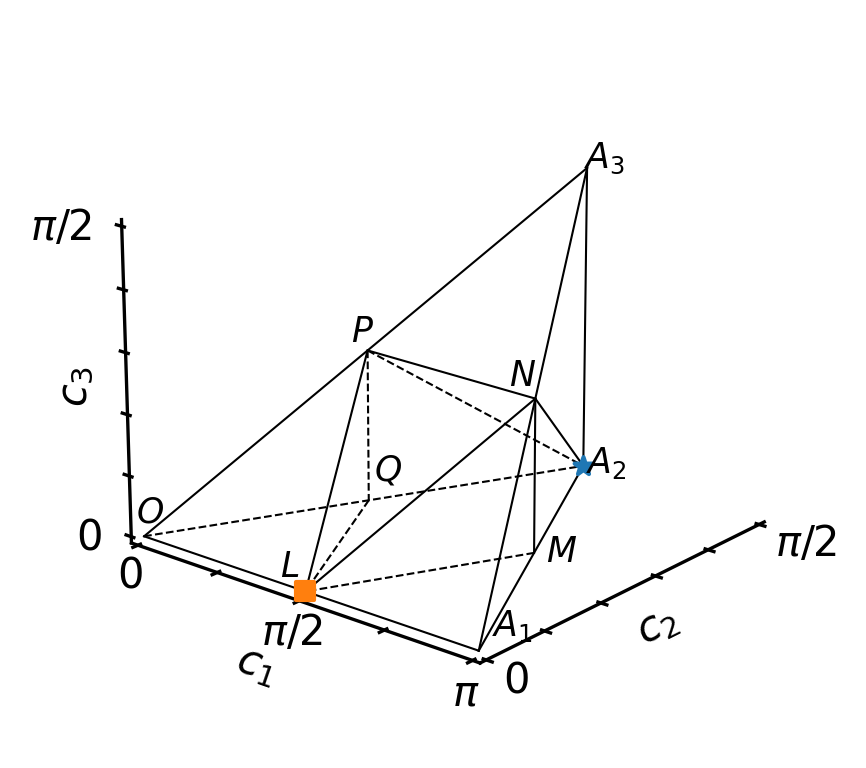

In [94]:
# test theory about displacement
w = WeylChamber()
interaction1 = QubitInteraction(np.pi / 2, 0)
sys1 = QubitSystem([(interaction1, (0, 1))], 2)
# print(sys1._construct_U_lambda()(t=1.0))
w.scatter(*c1c2c3(sys1._construct_U_lambda()(t=1.0)), marker="*")

interaction2 = QubitInteraction(np.pi / 4, np.pi / 4)
sys2 = QubitSystem([(interaction2, (0, 1))], 2)
# print(sys2._construct_U_lambda()(t=1.0))
w.scatter(*c1c2c3(sys2._construct_U_lambda()(t=1.0)), marker="s")

# joint system
sys = QubitSystem([(interaction1, (0, 1)), (interaction2, (1, 2))], 3)
joint_U = sys._construct_U_lambda()(t=1.0)
print(joint_U)

display(w.plot())

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = False
Qobj data =
[[ 0.76197608+0.j          0.        +0.j          0.        +0.j
   0.        -0.44800947j  0.        +0.j         -0.44800947+0.j
   0.        +0.13404286j  0.        +0.j        ]
 [ 0.        +0.j          0.76197608+0.j          0.        -0.44800947j
   0.        +0.j         -0.44800947+0.j          0.        +0.j
   0.        +0.j          0.        +0.13404286j]
 [ 0.        +0.j          0.        -0.44800947j -0.13404286+0.j
   0.        +0.j          0.        -0.76197608j  0.        +0.j
   0.        +0.j         -0.44800947+0.j        ]
 [ 0.        -0.44800947j  0.        +0.j          0.        +0.j
  -0.13404286+0.j          0.        +0.j          0.        -0.76197608j
  -0.44800947+0.j          0.        +0.j        ]
 [ 0.        +0.j         -0.44800947+0.j          0.        -0.76197608j
   0.        +0.j         -0.13404286+0.j          0.        +0.j
   0.    

None

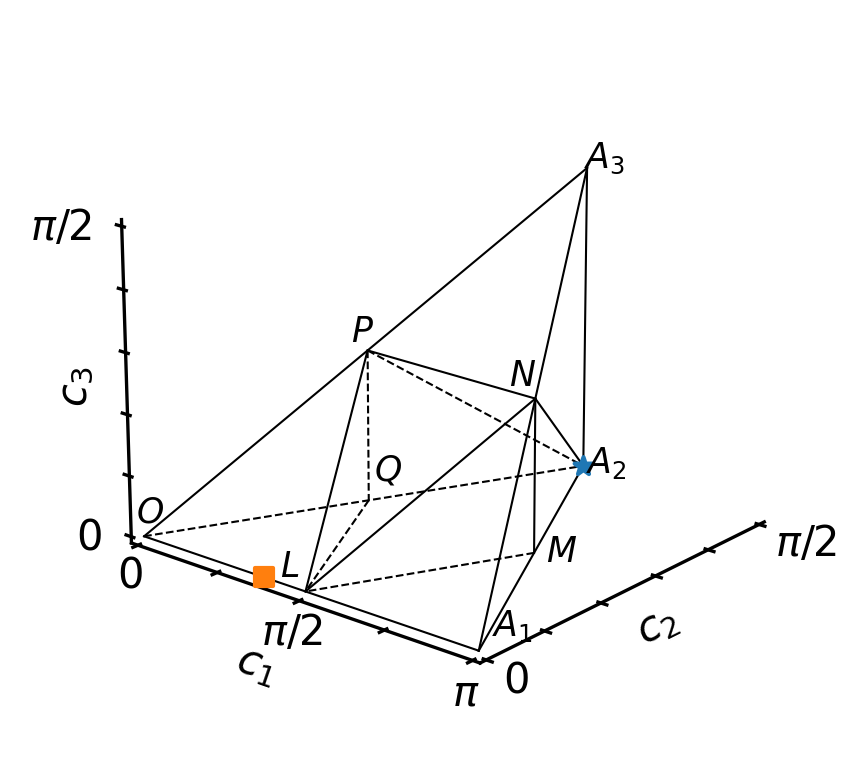

In [98]:
# test theory about displacement
w = WeylChamber()

# interaction1 will be variable we are looking for solution of, keep time fixed 1.0
interaction1 = QubitInteraction(np.pi / 2, 0)
sys1 = QubitSystem([(interaction1, (0, 1))], 2)
# print(sys1._construct_U_lambda()(t=1.0))
w.scatter(*c1c2c3(sys1._construct_U_lambda()(t=1.0)), marker="*")

# change t=0.75
interaction2 = QubitInteraction(np.pi / 4, np.pi / 4)
sys2 = QubitSystem([(interaction2, (0, 1))], 2)
# print(sys2._construct_U_lambda()(t=1.0))
w.scatter(*c1c2c3(sys2._construct_U_lambda()(t=0.75)), marker="s")

# joint system
sys = QubitSystem([(interaction1, (0, 1)), (interaction2, (1, 2))], 3)
joint_U = sys._construct_U_lambda()(t=1.0)
print(joint_U)

display(w.plot())